<a href="https://colab.research.google.com/github/yayanhidayaat/klasifikasi/blob/main/SKRRRPPPP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import shutil
from pathlib import Path
import pickle
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# 🔹 Path dataset di Google Drive dan lokal
GDRIVE_DATASET_PATH = "/content/drive/Shareddrives/STORE ASYFA/Yayan/riceleafs"
LOCAL_DATASET_PATH = "/content/riceleafs"
ZIP_FILE_PATH = "/content/riceleafs.zip"
RUNTIME_FILE = "/content/drive/Shareddrives/STORE ASYFA/Yayan/runtime.pkl"
KAGGLE_JSON_PATH = "/content/drive/Shareddrives/STORE ASYFA/Yayan/kaggle.json"

def check_and_copy_dataset():
    if os.path.exists(GDRIVE_DATASET_PATH) and len(os.listdir(GDRIVE_DATASET_PATH)) > 0:
        print("✅ Dataset ditemukan di Google Drive! Menyalin ke lokal...")
        if os.path.exists(LOCAL_DATASET_PATH):
            shutil.rmtree(LOCAL_DATASET_PATH)
        shutil.copytree(GDRIVE_DATASET_PATH, LOCAL_DATASET_PATH)
    else:
        download_dataset_from_kaggle()

def download_dataset_from_kaggle():
    print("⚠️ Dataset belum ada di Google Drive. Mengunduh dari Kaggle...")
    !pip install -q kaggle
    kaggle_config_dir = "/root/.kaggle"
    os.makedirs(kaggle_config_dir, exist_ok=True)
    if os.path.exists(KAGGLE_JSON_PATH):
        shutil.copy(KAGGLE_JSON_PATH, os.path.join(kaggle_config_dir, "kaggle.json"))
        os.chmod(os.path.join(kaggle_config_dir, "kaggle.json"), 0o600)
    else:
        raise FileNotFoundError("❌ kaggle.json tidak ditemukan di Google Drive!")
    if not os.path.exists(ZIP_FILE_PATH):
        print("🔽 Mengunduh dataset dari Kaggle...")
        os.system(f"kaggle datasets download -d shayanriyaz/riceleafs -p /content")
    extract_and_save_dataset()

def extract_and_save_dataset():
    if not os.path.exists(ZIP_FILE_PATH):
        raise FileNotFoundError(f"❌ Gagal mengunduh dataset. File {ZIP_FILE_PATH} tidak ditemukan!")
    print("📂 Mengekstrak dataset...")
    os.makedirs(LOCAL_DATASET_PATH, exist_ok=True)
    with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
        zip_ref.extractall(LOCAL_DATASET_PATH)
    print("💾 Menyimpan dataset ke Google Drive...")
    os.makedirs(GDRIVE_DATASET_PATH, exist_ok=True)
    shutil.copytree(LOCAL_DATASET_PATH, GDRIVE_DATASET_PATH, dirs_exist_ok=True)

def select_correct_dataset_folder():
    folder_option1 = os.path.join(LOCAL_DATASET_PATH, "RiceLeafs")
    folder_option2 = os.path.join(LOCAL_DATASET_PATH, "riceleafs")
    if os.path.exists(folder_option1):
        return folder_option1
    elif os.path.exists(folder_option2):
        return folder_option2
    else:
        raise FileNotFoundError(f"❌ Tidak ditemukan folder 'RiceLeafs' atau 'riceleafs' di dalam {LOCAL_DATASET_PATH}")

def save_runtime_data():
    runtime_data = {"dataset_downloaded": True, "download_path": LOCAL_DATASET_PATH}
    with open(RUNTIME_FILE, "wb") as f:
        pickle.dump(runtime_data, f)

check_and_copy_dataset()
dataset_path = select_correct_dataset_folder()
save_runtime_data()

print(f"\n✅ Dataset siap digunakan! Folder yang dipilih: {dataset_path}")
print("📂 Isi folder dataset:", os.listdir(dataset_path))


Mounted at /content/drive
⚠️ Dataset belum ada di Google Drive. Mengunduh dari Kaggle...
🔽 Mengunduh dataset dari Kaggle...
📂 Mengekstrak dataset...
💾 Menyimpan dataset ke Google Drive...

✅ Dataset siap digunakan! Folder yang dipilih: /content/riceleafs/RiceLeafs
📂 Isi folder dataset: ['train', 'validation']


In [2]:
import os
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from openpyxl import load_workbook

# 🔹 Menentukan path dataset
DATASET_PATH = "/content/drive/Shareddrives/STORE ASYFA/Yayan/riceleafs/RiceLeafs"

# 🔹 Kelas dalam dataset
CLASSES = ["BrownSpot", "Healthy", "Hispa", "LeafBlast"]

# 🔹 Menentukan direktori penyimpanan setelah preprocessing
PROCESSED_DATASET_NAME = "/content/drive/Shareddrives/STORE ASYFA/Yayan/riceleafs/Rice_Leafs_Dataset_Aug_Preprocessed_224x224"
SAVE_PATHS = {cls: os.path.join(PROCESSED_DATASET_NAME, cls) for cls in CLASSES}

# 🔹 Buat direktori penyimpanan jika belum ada
os.makedirs(PROCESSED_DATASET_NAME, exist_ok=True)
for cls in CLASSES:
    os.makedirs(SAVE_PATHS[cls], exist_ok=True)

print("✅ Path dataset dan penyimpanan preprocessing telah disiapkan!")


✅ Path dataset dan penyimpanan preprocessing telah disiapkan!


In [3]:
# 🔹 Isi file environment_setup.py
environment_setup_code = """# environment_setup.py

# Path ke dataset
DATASET_PATH = "/content/drive/Shareddrives/STORE ASYFA/Yayan/riceleafs/RiceLeafs"

# Kelas dalam dataset (ubah sesuai dengan dataset Anda)
CLASSES = ["Healthy", "Hispa", "BrownSpot", "LeafBlast"]

# Path penyimpanan setelah pemrosesan
PROCESSED_DATASET_NAME = "/content/drive/Shareddrives/STORE ASYFA/Yayan/riceleafs/Rice_Leafs_Dataset_Aug_Preprocessed_224x224"
SAVE_PATHS = {cls: f"{PROCESSED_DATASET_NAME}/{cls}" for cls in CLASSES}
"""

# 🔹 Membuat file environment_setup.py
with open("environment_setup.py", "w") as f:
    f.write(environment_setup_code)

print("✅ File environment_setup.py berhasil dibuat!")


✅ File environment_setup.py berhasil dibuat!


In [8]:
import os
import numpy as np
from pathlib import Path
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 🔹 Impor konfigurasi dari environment_setup.py
from environment_setup import DATASET_PATH, CLASSES, SAVE_PATHS

# 🔹 Mengecek apakah dataset tersedia
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"❌ Folder dataset '{DATASET_PATH}' tidak ditemukan!")

# 🔹 Mengumpulkan file gambar berdasarkan kelas
class_filespath = {cls: [] for cls in CLASSES}

for root, dirs, files in os.walk(DATASET_PATH):
    class_name = Path(root).name
    if class_name in class_filespath:
        for file in files:
            file_path = os.path.join(root, file)
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Hanya gambar
                class_filespath[class_name].append(file_path)

# 🔹 Hitung jumlah gambar sebelum augmentasi
original_counts = {cls: len(files) for cls, files in class_filespath.items()}
print(f"📊 Jumlah gambar sebelum augmentasi: {original_counts}")

# 🔹 Fungsi untuk mengubah gambar menjadi array dengan ukuran 224x224
def images_to_array(filespath, img_size=224):
    images_arr = []
    if not filespath:
        return images_arr

    for filepath in tqdm(filespath, desc="📸 Processing Images"):
        image = load_img(filepath, color_mode="rgb", target_size=(img_size, img_size))
        image_array = img_to_array(image)
        images_arr.append(image_array)

    return np.array(images_arr, dtype="float32")

# 🔹 Mengonversi dataset ke dalam array
arrays_to_save = {cls: images_to_array(class_filespath[cls]) for cls in CLASSES if class_filespath[cls]}

# 🔹 Menyimpan gambar yang telah diproses
for cls in arrays_to_save:
    save_path_images = os.path.join(SAVE_PATHS[cls], "images")
    os.makedirs(save_path_images, exist_ok=True)
    images = arrays_to_save[cls]

    for idx, image_arr in enumerate(tqdm(images, desc=f"💾 Saving {cls} images"), 1):
        save_img(os.path.join(save_path_images, f"{cls}_{idx}.jpg"), image_arr)

# 🔹 Augmentasi & Oversampling Data
if arrays_to_save:
    max_class = max(arrays_to_save, key=lambda cls: len(arrays_to_save[cls]))
    max_count = len(arrays_to_save[max_class])  # Jumlah gambar kelas terbesar

    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    for cls in arrays_to_save:
        save_path_images = os.path.join(SAVE_PATHS[cls], "images")
        image_count = len(arrays_to_save[cls])

        # 🔹 Augmentasi hanya jika jumlah gambar kurang dari kelas terbesar
        if image_count < max_count:
            oversample_count = max_count - image_count
            print(f"🔄 Augmenting '{cls}' ({image_count} ➝ {max_count})")

            images_to_augment = np.array(arrays_to_save[cls])  # Konversi list ke numpy array
            aug_images = []

            # Generator untuk augmentasi
            aug_generator = datagen.flow(
                images_to_augment,
                batch_size=1,  # Augmentasi per gambar
            )

            for _ in tqdm(range(oversample_count), desc=f"🔄 Generating augmented {cls} images"):
                batch = next(aug_generator)  # Ambil batch gambar dari generator
                aug_images.append(batch[0])  # Ambil satu gambar dari batch

            # Simpan hasil augmentasi
            for idx, image_arr in enumerate(aug_images, 1):
                save_img(os.path.join(save_path_images, f"{cls}_aug_{idx}.jpg"), image_arr)

            print(f"✅ {cls} selesai diaugmentasi ({image_count + len(aug_images)})")

# 🔹 Validasi jumlah gambar setelah augmentasi
final_counts = {cls: len(os.listdir(os.path.join(SAVE_PATHS[cls], "images"))) for cls in CLASSES}
print(f"\n📊 Jumlah gambar setelah augmentasi: {final_counts}")


📊 Jumlah gambar sebelum augmentasi: {'Healthy': 1488, 'Hispa': 565, 'BrownSpot': 523, 'LeafBlast': 779}


💾 Saving LeafBlast images: 100%|██████████| 779/779 [00:09<00:00, 83.69it/s]


🔄 Augmenting 'Hispa' (565 ➝ 1488)


🔄 Generating augmented Hispa images: 100%|██████████| 923/923 [00:12<00:00, 73.93it/s]


✅ Hispa selesai diaugmentasi (1488)
🔄 Augmenting 'BrownSpot' (523 ➝ 1488)


🔄 Generating augmented BrownSpot images: 100%|██████████| 965/965 [00:14<00:00, 68.00it/s]


✅ BrownSpot selesai diaugmentasi (1488)
🔄 Augmenting 'LeafBlast' (779 ➝ 1488)


🔄 Generating augmented LeafBlast images: 100%|██████████| 709/709 [00:09<00:00, 71.68it/s]


✅ LeafBlast selesai diaugmentasi (1488)

📊 Jumlah gambar setelah augmentasi: {'Healthy': 1488, 'Hispa': 1488, 'BrownSpot': 1488, 'LeafBlast': 1488}


<ipython-input-9-47ca1be39eb8>:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(CLASSES, rotation=30)
<ipython-input-9-47ca1be39eb8>:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(CLASSES, rotation=30)


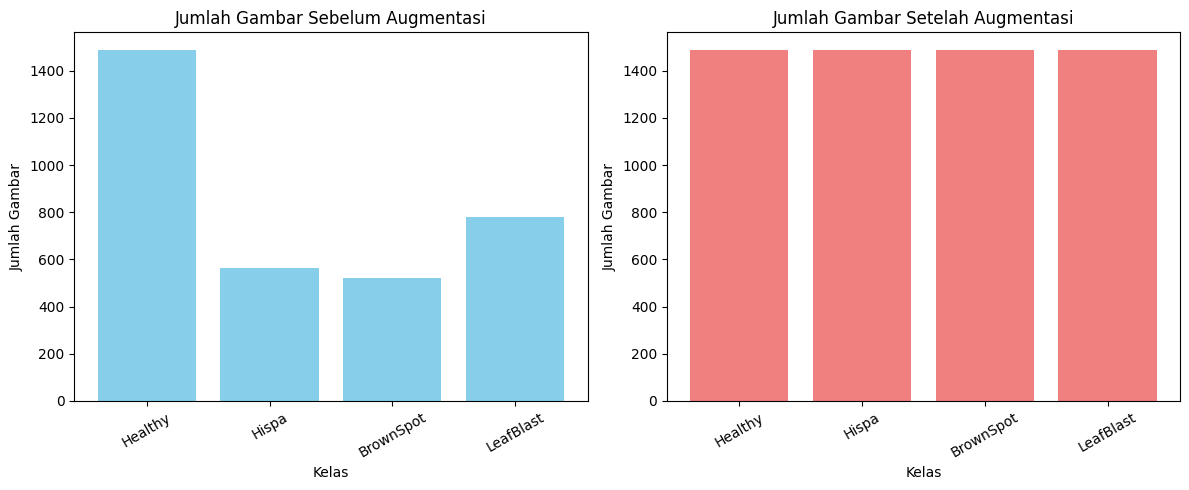

In [9]:
import os
import matplotlib.pyplot as plt
from environment_setup import CLASSES, SAVE_PATHS

# 🔹 Hitung jumlah gambar setelah augmentasi
augmented_counts = {cls: len(os.listdir(os.path.join(SAVE_PATHS[cls], "images"))) for cls in CLASSES}

# 🔹 Menampilkan grafik sebelum & sesudah augmentasi
def plot_data_distribution(original_counts, augmented_counts):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # 🔹 Grafik sebelum augmentasi
    axes[0].bar(original_counts.keys(), original_counts.values(), color='skyblue')
    axes[0].set_title("Jumlah Gambar Sebelum Augmentasi")
    axes[0].set_xlabel("Kelas")
    axes[0].set_ylabel("Jumlah Gambar")
    axes[0].set_xticklabels(CLASSES, rotation=30)

    # 🔹 Grafik setelah augmentasi
    axes[1].bar(augmented_counts.keys(), augmented_counts.values(), color='lightcoral')
    axes[1].set_title("Jumlah Gambar Setelah Augmentasi")
    axes[1].set_xlabel("Kelas")
    axes[1].set_ylabel("Jumlah Gambar")
    axes[1].set_xticklabels(CLASSES, rotation=30)

    plt.tight_layout()
    plt.show()

# 🔹 Panggil fungsi plotting
plot_data_distribution(original_counts, augmented_counts)


In [13]:
import os
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from tqdm import tqdm
from environment_setup import DATASET_PATH, CLASSES  # Impor variabel lingkungan

# 🔹 Path ke folder Train & Validation
TRAIN_PATH = os.path.join(DATASET_PATH, "train")
VAL_PATH = os.path.join(DATASET_PATH, "validation")

# 🔹 Menyimpan path gambar dan label
train_images_path, val_images_path = [], []
train_labels, val_labels = [], []

# 🔹 Fungsi untuk mengumpulkan gambar dari folder
def collect_images(folder_path, label_storage, image_storage):
    for label in CLASSES:
        label_path = os.path.join(folder_path, label)

        if not os.path.exists(label_path):
            print(f"⚠️ Folder tidak ditemukan: {label_path}")
            continue

        image_files = [
            os.path.join(label_path, f)
            for f in os.listdir(label_path)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]

        if len(image_files) == 0:
            print(f"⚠️ Tidak ada gambar di kelas '{label}', dilewati.")
            continue

        image_storage.extend(image_files)
        label_storage.extend([label] * len(image_files))

# 🔹 Mengumpulkan data train dan validation
collect_images(TRAIN_PATH, train_labels, train_images_path)
collect_images(VAL_PATH, val_labels, val_images_path)

# 🔹 One-Hot Encoding untuk label
one_hot_enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
train_labels_onehot = one_hot_enc.fit_transform([[lbl] for lbl in train_labels])
val_labels_onehot = one_hot_enc.transform([[lbl] for lbl in val_labels])

# 🔹 Mengacak data train untuk menghindari bias
train_images_path, train_labels, train_labels_onehot = shuffle(
    train_images_path, train_labels, train_labels_onehot, random_state=42
)

# 🔹 Print hasil pemrosesan
print("\n✅ Dataset berhasil diproses!")
print(f"🔹 Jumlah gambar Train     : {len(train_images_path)}")
print(f"🔹 Jumlah gambar Validation: {len(val_images_path)}")



✅ Dataset berhasil diproses!
🔹 Jumlah gambar Train     : 2684
🔹 Jumlah gambar Validation: 671


In [16]:
import os
import pandas as pd
from sklearn.model_selection import KFold
from environment_setup import CLASSES  # Ambil daftar kelas

# Menentukan parameter
N_SPLITS = 5
OUTPUT_FILE = "dataset_splits.xlsx"

# K-Fold Split
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

with pd.ExcelWriter(OUTPUT_FILE, engine="xlsxwriter") as writer_excel:
    for i, (train_idx, val_idx) in enumerate(kf.split(train_images_path), start=1):
        fold_train_images = [train_images_path[idx] for idx in train_idx]
        fold_val_images = [train_images_path[idx] for idx in val_idx]

        fold_train_labels = [train_labels[idx] for idx in train_idx]
        fold_val_labels = [train_labels[idx] for idx in val_idx]

        fold_train_labels_onehot = train_labels_onehot[train_idx]
        fold_val_labels_onehot = train_labels_onehot[val_idx]

        # Membuat DataFrame Train & Validation
        def create_dataframe(image_paths, labels, one_hot_labels):
            df = pd.DataFrame({
                "image_path": image_paths,
                "label": labels
            })
            for j, class_name in enumerate(CLASSES):  # Loop untuk one-hot encoding kolom dinamis
                df[class_name] = one_hot_labels[:, j]
            return df

        train_df = create_dataframe(fold_train_images, fold_train_labels, fold_train_labels_onehot)
        val_df = create_dataframe(fold_val_images, fold_val_labels, fold_val_labels_onehot)

        # Menyimpan ke Excel
        train_df.to_excel(writer_excel, sheet_name=f"Fold_{i}_Train", index=False)
        val_df.to_excel(writer_excel, sheet_name=f"Fold_{i}_Val", index=False)

print(f"✅ Data split telah disimpan di {OUTPUT_FILE}")


✅ Data split telah disimpan di dataset_splits.xlsx


In [21]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Konstanta (sesuaikan dengan kebutuhan)
EXCEL_FILENAME = "dataset_splits.xlsx"  # Nama file Excel yang digunakan
IMG_SIZE = 224  # Ukuran gambar yang diinginkan
LABEL_COLUMNS = ['Healthy', 'Hispa', 'BrownSpot', 'LeafBlast']  # Nama label yang benar

def getArrFromExcel(sheet_name):
    """
    Membaca dataset dari file Excel dan mengonversinya menjadi array gambar dan label.

    Parameters:
        sheet_name (str): Nama sheet dalam file Excel yang akan dibaca.

    Returns:
        tuple: (numpy.ndarray dari gambar, numpy.ndarray dari label)
    """
    try:
        # Membaca file Excel
        df = pd.read_excel(EXCEL_FILENAME, sheet_name=sheet_name)
        print(f"✅ Sheet '{sheet_name}' berhasil dibaca.")

        # Menampilkan kolom yang tersedia
        print(f"📊 Kolom yang ditemukan di dataset: {list(df.columns)}")

        # Periksa apakah kolom one-hot ada
        if not all(col in df.columns for col in LABEL_COLUMNS):
            print(f"⚠️ Kolom label one-hot tidak ditemukan. Periksa kembali file Excel!")
            return None, None

        # Mengambil path gambar dan label one-hot
        images_path = df["image_path"].values
        labels = df[LABEL_COLUMNS].values  # Menggunakan label yang benar

        # Menyimpan array gambar
        images_arr = []

        for image_path in tqdm(images_path, desc="📸 Loading Images"):
            try:
                img = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
                images_arr.append(img_to_array(img))
            except Exception as e:
                print(f"❌ Error loading image {image_path}: {e}")

        print(f"✅ Dataset dari '{sheet_name}' berhasil dikonversi!")
        return np.array(images_arr, dtype="float32"), np.array(labels, dtype="float32")

    except Exception as e:
        print(f"❌ Error membaca file Excel: {e}")
        return None, None

# Contoh penggunaan
images, labels = getArrFromExcel("Fold_1_Train")

if images is not None and labels is not None:
    print(f"✅ Dataset berhasil dimuat: Gambar {images.shape}, Label {labels.shape}")
else:
    print("⚠️ Terjadi kesalahan saat memuat dataset.")


✅ Sheet 'Fold_1_Train' berhasil dibaca.
📊 Kolom yang ditemukan di dataset: ['image_path', 'label', 'Healthy', 'Hispa', 'BrownSpot', 'LeafBlast']


📸 Loading Images: 100%|██████████| 2147/2147 [03:48<00:00,  9.38it/s]


✅ Dataset dari 'Fold_1_Train' berhasil dikonversi!
✅ Dataset berhasil dimuat: Gambar (2147, 224, 224, 3), Label (2147, 4)


In [22]:
import tensorflow as tf
from tensorflow.keras import layers, applications

# Konstanta
IMG_SIZE = 224
NUM_CLASSES = 4

def build_scratch_model():
    """Model tanpa transfer learning (train from scratch)"""
    base_model = applications.MobileNetV2(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights=None)
    base_model.trainable = True
    return tf.keras.Sequential([
        base_model, layers.GlobalAveragePooling2D(), layers.Dense(512, activation="relu"), layers.Dense(NUM_CLASSES, activation="softmax")
    ])

def build_fixed_feature_extraction_model():
    """Transfer Learning - Fixed Feature Extraction"""
    base_model = applications.MobileNetV2(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights="imagenet")
    base_model.trainable = False
    return tf.keras.Sequential([
        base_model, layers.GlobalAveragePooling2D(), layers.Dense(512, activation="relu"), layers.Dense(NUM_CLASSES, activation="softmax")
    ])

def build_finetune_first_layer():
    """Transfer Learning - Fine-Tuning First Layer"""
    base_model = applications.MobileNetV2(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights="imagenet")
    base_model.trainable = False
    base_model.layers[0].trainable = True  # Unfreeze first layer
    return tf.keras.Sequential([
        base_model, layers.GlobalAveragePooling2D(), layers.Dense(512, activation="relu"), layers.Dense(NUM_CLASSES, activation="softmax")
    ])

def build_finetune_middle_layer():
    """Transfer Learning - Fine-Tuning Middle Layer"""
    base_model = applications.MobileNetV2(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights="imagenet")
    base_model.trainable = False
    total_layers = len(base_model.layers)
    middle_layer_index = total_layers // 2  # Ambil indeks tengah

    # Fine-tune sekitar 10 layer di tengah
    fine_tune_range = 5  # Bisa diubah sesuai kebutuhan
    for layer in base_model.layers[middle_layer_index - fine_tune_range : middle_layer_index + fine_tune_range]:
        layer.trainable = True

    return tf.keras.Sequential([
        base_model, layers.GlobalAveragePooling2D(), layers.Dense(512, activation="relu"), layers.Dense(NUM_CLASSES, activation="softmax")
    ])

def build_finetune_last_layer(ft_layers=25):
    """Transfer Learning - Fine-Tuning Last Layer"""
    base_model = applications.MobileNetV2(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights="imagenet")
    base_model.trainable = False
    for layer in base_model.layers[-ft_layers:]: layer.trainable = True  # Unfreeze last N layers
    return tf.keras.Sequential([
        base_model, layers.GlobalAveragePooling2D(), layers.Dense(512, activation="relu"), layers.Dense(NUM_CLASSES, activation="softmax")
    ])

# Inisialisasi model
models = {
    "Scratch": build_scratch_model(),
    "Fixed_Feature": build_fixed_feature_extraction_model(),
    "Fine_Tune_First": build_finetune_first_layer(),
    "Fine_Tune_Middle": build_finetune_middle_layer(),
    "Fine_Tune_Last": build_finetune_last_layer()
}

# Kompilasi model
for name, model in models.items():
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    print(f"✅ Model '{name}' siap untuk dilatih!")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ Model 'Scratch' siap untuk dilatih!
✅ Model 'Fixed_Feature' siap untuk dilatih!
✅ Model 'Fine_Tune_First' siap untuk dilatih!
✅ Model 'Fine_Tune_Middle' siap untuk dilatih!
✅ Model 'Fine_Tune_Last' siap untuk dilatih!


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, Callback
from sklearn.model_selection import KFold
from tqdm import tqdm

# ✅ Gunakan MirroredStrategy dengan cara yang benar
STRATEGY = tf.distribute.MirroredStrategy()
print("✅ MirroredStrategy berhasil digunakan!")

# Konfigurasi
NUM_CLASSES, IMG_SIZE, LR, BATCH_SIZE, EPOCHS = 4, 300, 0.0001, 32, 50
OUTPUT_FILE = "dataset_splits.xlsx"
KFOLDS = 5

# ✅ Callback untuk menghitung waktu per epoch
class TimingCallback(Callback):
    def __init__(self):
        self.logs = []
    def on_epoch_begin(self, epoch, logs=None):
        self.starttime = tf.timestamp()
    def on_epoch_end(self, epoch, logs=None):
        self.logs.append(float(tf.timestamp() - self.starttime))

# ✅ Fungsi membaca dataset dari Excel
def getArrFromExcel(sheet_name):
    df = pd.read_excel(OUTPUT_FILE, sheet_name=sheet_name)
    print(f"✅ Sheet '{sheet_name}' berhasil dibaca.")

    # Pastikan semua kolom tersedia
    print(f"📊 Kolom yang ditemukan di dataset: {list(df.columns)}")

    if "image_path" not in df.columns:
        raise KeyError("❌ Kolom 'image_path' tidak ditemukan dalam dataset!")

    # Cek kolom one-hot encoding berdasarkan nama selain image_path dan label
    label_columns = [col for col in df.columns if col not in ["image_path", "label"]]
    if not label_columns:
        raise KeyError("⚠️ Kolom label one-hot tidak ditemukan. Periksa kembali file Excel!")

    images_path = df["image_path"].values
    labels = df[label_columns].values

    images_arr = []
    for image_path in tqdm(images_path, desc=f"📸 Loading {sheet_name}"):
        try:
            img = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
            images_arr.append(img_to_array(img))
        except Exception as e:
            print(f"❌ Error loading {image_path}: {e}")

    return np.array(images_arr, dtype="float32"), np.array(labels, dtype="float32")

# ✅ Fungsi membangun model
def build_model(mode="no_tl"):
    base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights="imagenet" if "tl" in mode else None)

    if mode == "tl_fixed":
        base_model.trainable = False
    elif mode == "tl_first":
        for layer in base_model.layers[:10]:
            layer.trainable = True
    elif mode == "tl_middle":
        mid_layer = len(base_model.layers) // 2
        for layer in base_model.layers[mid_layer-10:mid_layer+10]:
            layer.trainable = True
    elif mode == "tl_last":
        for layer in base_model.layers[-10:]:
            layer.trainable = True
    else:
        base_model.trainable = True

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    output_layer = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output_layer)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# ✅ Training dengan K-Fold
for mode in ["no_tl", "tl_fixed", "tl_first", "tl_middle", "tl_last"]:
    drive_path = f"Training/MobileNetV2-{mode}"
    os.makedirs(drive_path, exist_ok=True)

    # ✅ Ambil dataset sekali saja
    train_images, train_labels = getArrFromExcel("Fold_1_Train")

    kf = KFold(n_splits=KFOLDS, shuffle=True, random_state=42)

    for fold, (train_idx, val_idx) in enumerate(kf.split(train_images), start=1):
        train_images_fold, val_images_fold = train_images[train_idx], train_images[val_idx]
        train_labels_fold, val_labels_fold = train_labels[train_idx], train_labels[val_idx]

        csv_logger_filename = os.path.join(drive_path, f"csv_logger_fold_{fold}.csv")
        model_checkpoint_filename = os.path.join(drive_path, f"model_fold_{fold}.h5")

        callbacks = [
            CSVLogger(csv_logger_filename),
            TimingCallback(),
            ModelCheckpoint(filepath=model_checkpoint_filename, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1),
            EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1)
        ]

        with STRATEGY.scope():
            model = build_model(mode)
            model.fit(train_images_fold, train_labels_fold,
                      validation_data=(val_images_fold, val_labels_fold),
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks)

print("✅ Training selesai!")


✅ MirroredStrategy berhasil digunakan!
✅ Sheet 'Fold_1_Train' berhasil dibaca.
📊 Kolom yang ditemukan di dataset: ['image_path', 'label', 'Healthy', 'Hispa', 'BrownSpot', 'LeafBlast']


📸 Loading Fold_1_Train:   4%|▎         | 80/2147 [00:18<06:52,  5.01it/s]